## Proximity

The Proximity tools let you perform analyses using one of three distance metrics: Euclidean (straight-line), Manhattan (with path obstacles, i.e., taxicab distance), and Great Cricle (distance on the surface of a sphere).

- [Proximity Distance](#Proximity-Distance): Calculates the distance to the nearest of a set of target - or source - points for each point in the input raster.
- [Proximity Allocation](#Proximity-Allocation): Identifies the nearest source (target) point (the 'allocation' point) for each cell in the input raster.
- [Proximity Direction](#Proximity-Direction): Returns the direction to the nearest source point (the 'allocation') for each cell in the input raster.

### Importing Packages

In [1]:
import numpy as np
import pandas as pd

import datashader as ds
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

### Proximity Distance

The `xrspatial.proximity` function operates on a given values aggregate to produce a new distance aggregate based on a set of target values and using a distance metric. The metric is used to calculate the distance at each each array cell (pixel) in the values aggregate from the nearest of the target points. For `proximity`, this smallest distance is set as each cell's value in the returned aggregate.

A powerful feature of `proximity` is that you can target specific points, the `target_values` parameter, in the aggregate for distance calculation and ignore the rest. If this isn't set, then all non-zero pixels are set as targets. Feel free to play with the parameter and see the difference between using `target_values=[1,2,3,4]` vs. the default option. 

Let's set up a values aggregate raster and try out the proximity function.

- We can set up a regular cell-grid aggregate with datashader's `Canvas.points`.
- We'll set this one up in reverse to make it easier.
- We define the target points in a pandas DataFrame
- We aggregate those with Canvas.points into an aggregates raster, which embeds the target points into a large grid of nan's.
- We change all the non-target points from nan to 0.

Now we have an aggregate raster full of zeros but with a few non-zero target/source points at our desired locations and each with a unique 'id' value.

We'll set a quick shade and background to visualize this.

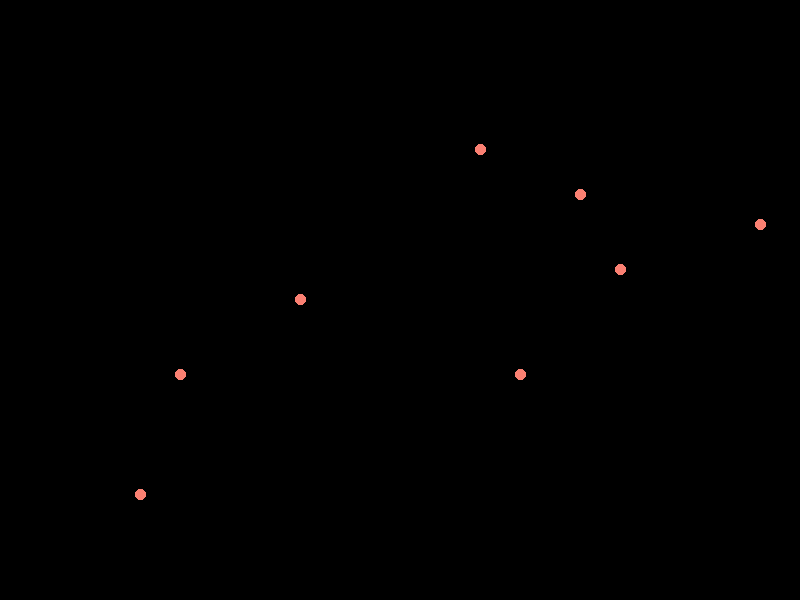

In [2]:
from xrspatial import proximity
import pandas as pd

df = pd.DataFrame(
    {
        "x": [-13, -11, -5, 4, 9, 11, 18, 6],
        "y": [-13, -5, 0, 10, 7, 2, 5, -5],
        "id": [1, 2, 3, 4, 5, 6, 7, 8],
    }
)

W = 800
H = 600

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20, 20), y_range=(-20, 20))

points_agg = cvs.points(df, x="x", y="y", agg=ds.min("id"))
points_agg.data[~np.isfinite(points_agg.data)] = 0

points_shaded = dynspread(
    shade(points_agg, cmap="salmon", min_alpha=0, span=(0, 1), how="linear"),
    threshold=1,
    max_px=5,
)
set_background(points_shaded, "black")

#### Apply Proximity

Now we can apply the proximity function to our points aggregate.

##### Set Targets

We can set the target_values parameter to a subset of the points, for example, \[1, 2, 3, 4\], to only measure distance everywhere from the nearest of these four points.

Let's do that, and then shade it for visualization.

Note: feel free to remove or add to the targets from among the digits 1-8 and see how the image changes.

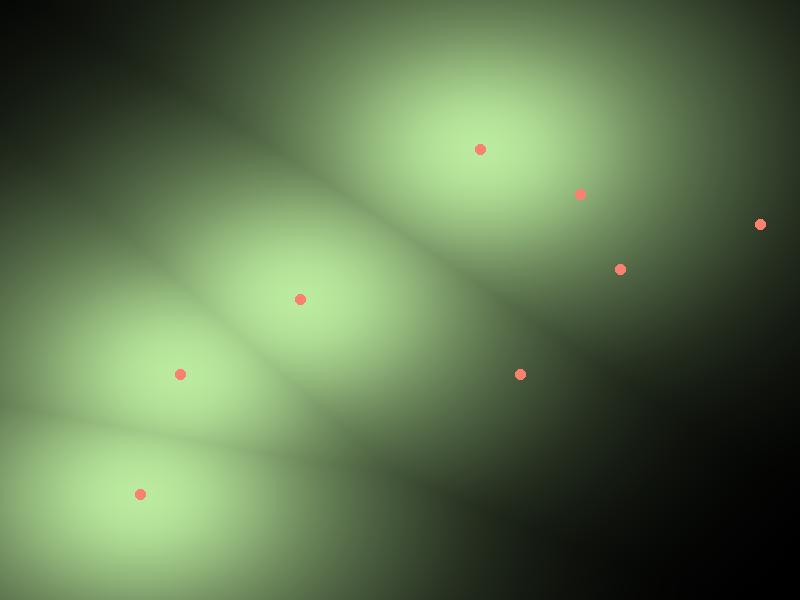

In [3]:
targets = [1, 2, 3, 4]
target_proximity_agg = proximity(
    points_agg, target_values=targets, distance_metric="GREAT_CIRCLE"
)

stack(
    shade(target_proximity_agg, cmap=["#bbeb9e", "black"], how="eq_hist"), points_shaded
)

Note the brighter areas nearer the target points and the black lines along areas that are equal distance to two points. 

##### Proximity with Default Targets: All Non-zero Points

Leaving out the target_values parameter entirely defaults it to all non-zero points.

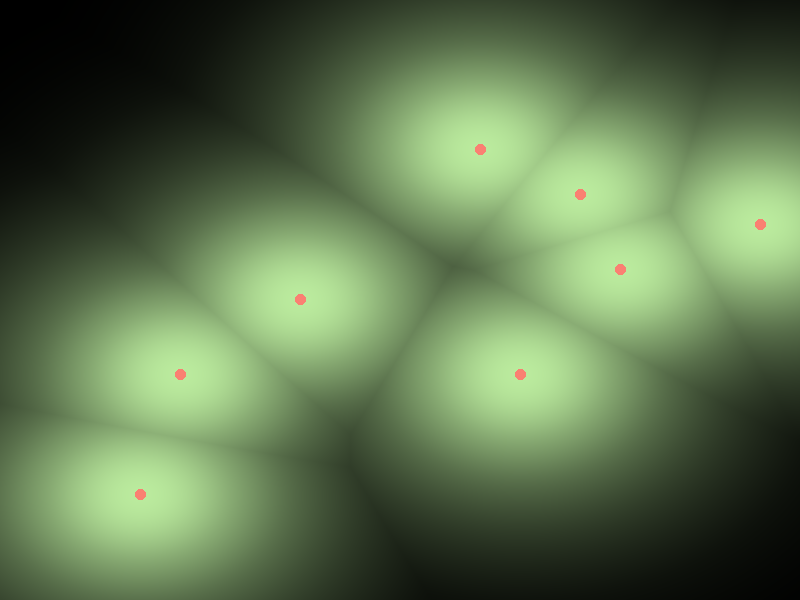

In [4]:
proximity_agg = proximity(points_agg, distance_metric="GREAT_CIRCLE")

stack(shade(proximity_agg, cmap=["#bbeb9e", "black"], how="eq_hist"), points_shaded)

#### Apply proximity to a line

Proximity can be applied to any shape appregate, so applying it to a raster aggregate of lines works as well. 

For a quick example we can once again aggregate the points DataFrame from above, but, using Canvas.line, into lines rather than isolated points.

Take a look below.

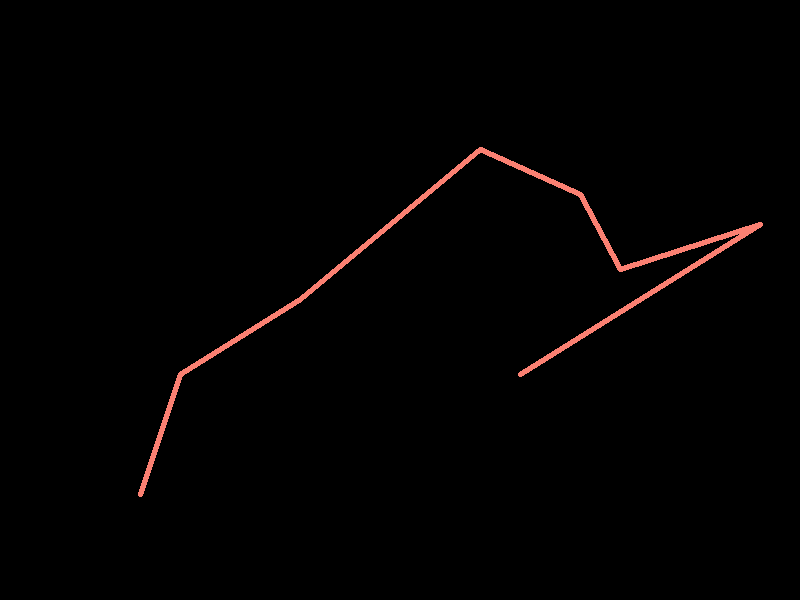

In [5]:
line_agg = cvs.line(df, x="x", y="y")
line_shaded = dynspread(
    shade(line_agg, cmap=["salmon", "salmon"]), threshold=1, max_px=2
)
set_background(line_shaded, "black")

##### Apply `proximity`

Now we can apply proximity and it gives us the smallest distance at every cell from any point on the line.

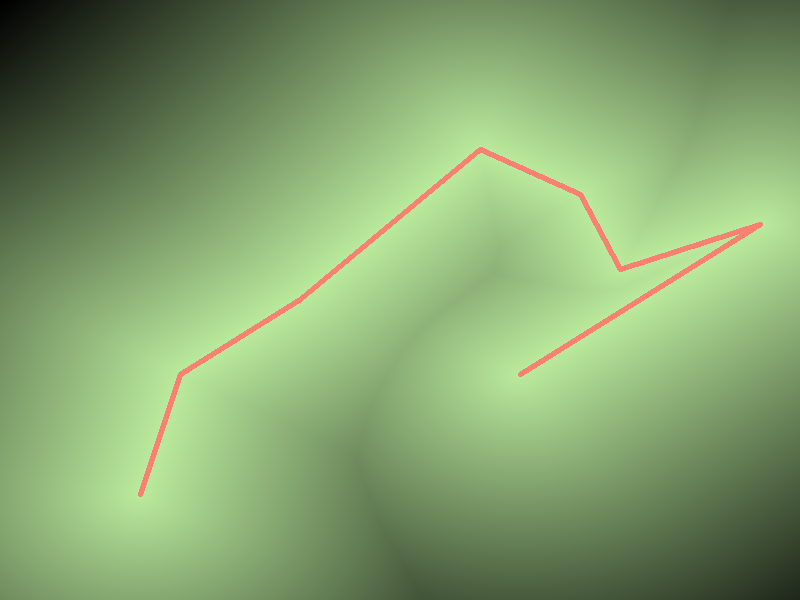

In [6]:
line_proximity = proximity(line_agg)
stack(shade(line_proximity, cmap=["#bbeb9e", "black"], how="linear"), line_shaded)

##### Apply Proximity with transformations

Since Xarray-spatial is built on Xarray and Numpy, we can also use proximity and then apply some nifty transformations from the wide range of transformations available through the xarray DataArray API.

Here's an example using `DataArray.where()`:
- We'll bring in the line_proximity we calculated above.
- Then we'll put a minimum and maximum distance clause into `DataArray.where()`.

The result is shaded and visualized below. As you can see, this provides a neat ouline around the line.

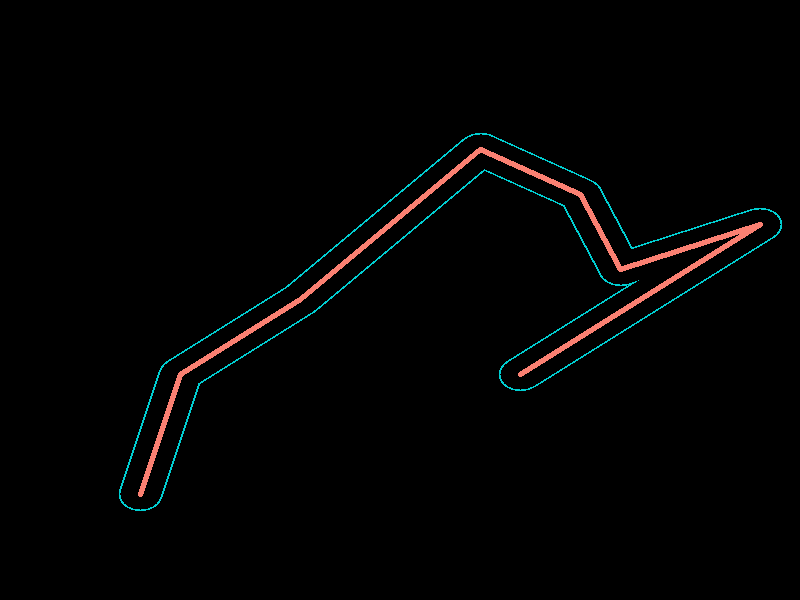

In [7]:
where_clause = (line_proximity > 1) & (line_proximity < 1.1)
proximity_shaded = shade(
    line_proximity.where(where_clause), cmap=["darkturquoise", "darkturquoise"]
)
proximity_shaded = set_background(proximity_shaded, "black")
stack(proximity_shaded, line_shaded)

### Proximity Allocation

Similar to `xrspatial.proximity`, the `xrspatial.allocation` function operates on an aggregate and finds the smallest distance from each cell to any one of the target, or source, points. But, instead of the distance, it returns the value at that source point and sets the current cell to that value. So, the result is a raster with block areas, with all cells in each area set to the value of that area's nearest source.

In the same way as for `proximity`, we can set the target points with the `target_values` parameter.

Let's apply allocation to our aggregate from above, leaving the default all target points active.

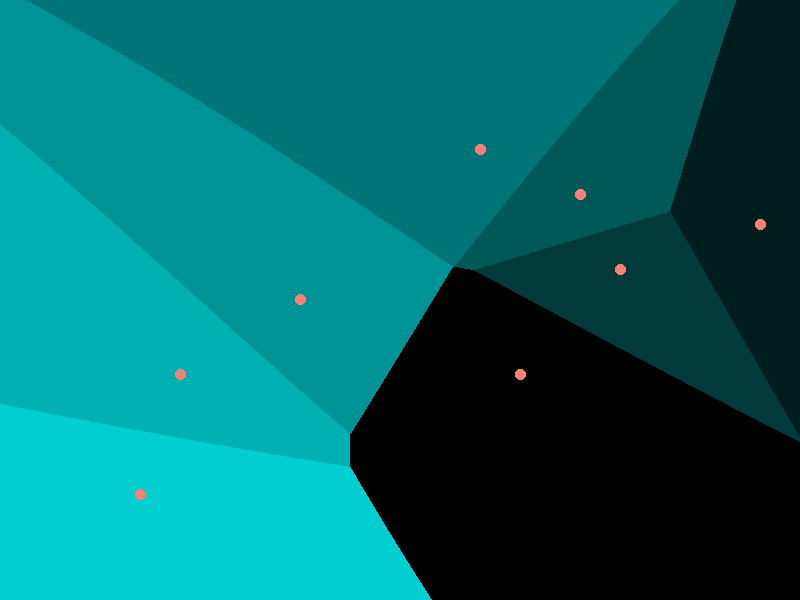

In [8]:
from xrspatial import allocation

allocation_agg = allocation(points_agg, distance_metric="GREAT_CIRCLE")

stack(
    shade(allocation_agg, cmap=["darkturquoise", "black"], how="linear"), points_shaded
)

Notice the blocks: each of the differently shaded blocks contains all of the points that have the target point in the center as their nearest target point.

### Proximity Direction

Also similar to `xrspatial.proximity`, `xrspatial.direction` also starts by calculating the smallest distance for each cell to a source point. But, instead of distance, it returns the direction in degrees to that nearest source point. The output values range from 0 to 360:
- 0 is for the source cell itself
- 90 is the east
- 180 is the south
- 270 is the west
- 360 is the north

Once again, you can target specific values with the `target_values` parameter.

Let's apply it to our aggrega from above, leaving all the default target points active.

(Note: the image is from a north point-of-view; i.e. north is down.)

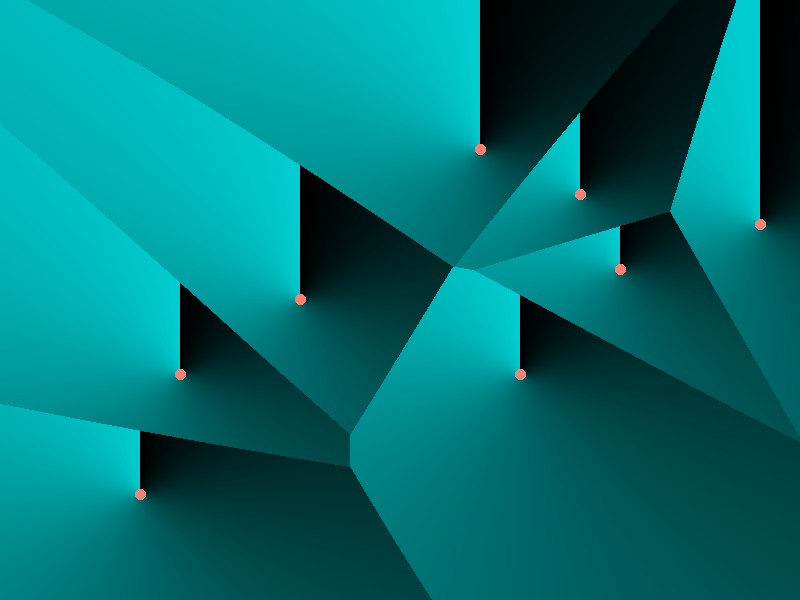

In [9]:
from xrspatial import direction

direction_agg = direction(points_agg, distance_metric="GREAT_CIRCLE")

stack(
    shade(direction_agg, cmap=["darkturquoise", "black"], how="linear"), points_shaded
)

### References

An overview of the Distance toolset: https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/an-overview-of-the-distance-tools.htm